In [2]:
#importing all necessary libraries
from datetime import datetime
# globalstart = datetime.now()
import pandas as pd
import numpy as np
import matplotlib
matplotlib.use('nbagg')

import matplotlib.pyplot as plt
plt.rcParams.update({'figure.max_open_warning': 0})

import seaborn as sns
sns.set_style('whitegrid')
import os
from scipy import sparse
from scipy.sparse import csr_matrix

from sklearn.decomposition import TruncatedSVD
from sklearn.metrics.pairwise import cosine_similarity
import random

In [3]:
start = datetime.now()
if not os.path.isfile('data.csv'):
    # Create a file 'data.csv' before reading it
    data = open('data.csv', mode='w')
    
    row = list()
    files=['movie_data'
 
           ]
    for file in files:
        print("Reading ratings from {}...".format(file))
        with open(file) as f:
            for line in f: 
                del row[:] # you don't have to do this.
                line = line.strip()
                if line.endswith(':'):
                    # All below are ratings for this movie, until another movie appears.
                    movie_id = line.replace(':', '')
                else:
                    row = [x for x in line.split(',')]
                    row.insert(0, movie_id)
                    data.write(','.join(row))
                    data.write('\n')
        print("Done.\n")
    data.close()
print('Time took :', datetime.now() - start)

Time took : 0:00:00.001011


In [4]:
print("creating the dataframe from data.csv file..")
df = pd.read_csv('data.csv', sep=',', 
                       names=['movie', 'user','rating','date'])
df.date = pd.to_datetime(df.date)
print('Done creating dataframe\n')

# we are arranging the ratings according to time.
print('Sorting the dataframe by date..')
df.sort_values(by='date', inplace=True)
print('Done..')

creating the dataframe from data.csv file..
Done creating dataframe

Sorting the dataframe by date..
Done..


In [5]:
df.count()

movie     789223
user      789223
rating    789222
date      789222
dtype: int64

In [6]:
df.describe()['rating']

count    789222.000000
mean          3.639254
min           1.000000
25%           3.000000
50%           4.000000
75%           4.000000
max           5.000000
std           1.060572
Name: rating, dtype: float64

<h3>Checking for NaN values </h3>

In [7]:
# just to make sure that all Nan containing rows are deleted..
df=df.dropna()
print("No of Nan values in our dataframe : ", sum(df.isnull().any()))

No of Nan values in our dataframe :  0


<h3> Removing Duplicates </h3>

In [8]:
dup_bool = df.duplicated(['movie','user','rating'])
dups = sum(dup_bool) # by considering all columns..( including timestamp)
print("There are {} duplicate rating entries in the data..".format(dups))

There are 1684 duplicate rating entries in the data..


 <h3> Basic Statistics (#Ratings, #Users, and #Movies)</h3>

In [9]:
print("Total data ")
print("-"*50)
print("\nTotal no of ratings :",df.shape[0])
print("Total No of Users   :", len(np.unique(df.user)))
print("Total No of movies  :", len(np.unique(df.movie)))

Total data 
--------------------------------------------------

Total no of ratings : 789222
Total No of Users   : 261134
Total No of movies  : 169


<h2> Spliting data into Train and Test(80:20) </h2>

In [10]:
if not os.path.isfile('train.csv'):
    # create the dataframe and store it in the disk for offline purposes..
    df.iloc[:int(df.shape[0]*0.80)].to_csv("train.csv", index=False)

if not os.path.isfile('test.csv'):
    # create the dataframe and store it in the disk for offline purposes..
    df.iloc[int(df.shape[0]*0.80):].to_csv("test.csv", index=False)

train_df = pd.read_csv("train.csv", parse_dates=['date'])
test_df = pd.read_csv("test.csv")

<h3> Basic Statistics in Train data (Ratings, Users, and Movies)</h3>

In [11]:
# movies = train_df.movie.value_counts()
# users = train_df.user.value_counts()
print("Training data ")
print("-"*50)
print("\nTotal no of ratings :",train_df.shape[0])
print("Total No of Users   :", len(np.unique(train_df.user)))
print("Total No of movies  :", len(np.unique(train_df.movie)))

Training data 
--------------------------------------------------

Total no of ratings : 631377
Total No of Users   : 214284
Total No of movies  : 165


<h3> Basic Statistics in Test data (#Ratings, #Users, and #Movies)</h3>

In [12]:
print("Test data ")
print("-"*50)
print("\nTotal no of ratings :",test_df.shape[0])
print("Total No of Users   :", len(np.unique(test_df.user)))
print("Total No of movies  :", len(np.unique(test_df.movie)))

Test data 
--------------------------------------------------

Total no of ratings : 157845
Total No of Users   : 87199
Total No of movies  : 169


 <h2> Exploratory Data Analysis on Train data </h2>

In [13]:
# It is used to skip the warning ''SettingWithCopyWarning''.. 
pd.options.mode.chained_assignment = None  # default='warn'

train_df['day_of_week'] = train_df.date.dt.day_name()

train_df.tail()

,movie,user,rating,date,day_of_week
631372,30,63786,2.0,2005-07-10,Sunday
631373,58,181273,4.0,2005-07-10,Sunday
631374,175,2067593,4.0,2005-07-10,Sunday
631375,30,2152621,4.0,2005-07-10,Sunday
631376,168,1757577,2.0,2005-07-10,Sunday


<h3> Analysis on the Ratings given by user </h3>

In [14]:
no_of_rated_movies_per_user = train_df.groupby(by='user')['rating'].count().sort_values(ascending=False)

no_of_rated_movies_per_user.head()

user
305344     161
387418     144
2439493    144
1639792     88
1461435     83
Name: rating, dtype: int64

In [16]:
no_of_rated_movies_per_user.describe()

count    214284.00000
mean          2.94645
std           2.85358
min           1.00000
25%           1.00000
50%           2.00000
75%           4.00000
max         161.00000
Name: rating, dtype: float64

<h3> Number of ratings on each day of the week</h3>

<IPython.core.display.Javascript object>


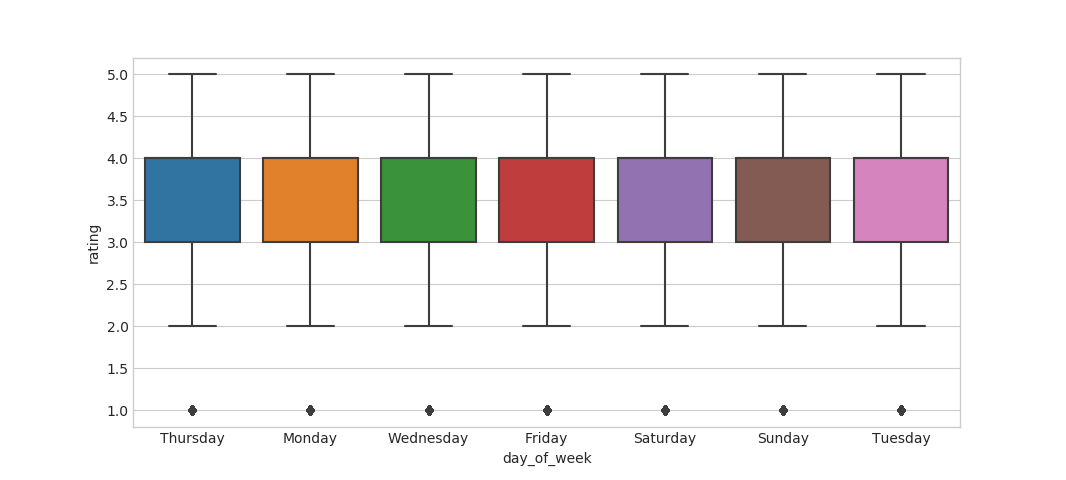

0:01:10.003761


In [ ]:
start = datetime.now()
fig = plt.figure(figsize=plt.figaspect(.45))
sns.boxplot(y='rating', x='day_of_week', data=train_df)
plt.show()
print(datetime.now() - start)

In [19]:
avg_week_df = train_df.groupby(by=['day_of_week'])['rating'].mean()
print(" AVerage ratings")
print("-"*30)
print(avg_week_df)
print("\n")

 AVerage ratings
------------------------------
day_of_week
Friday       3.617769
Monday       3.620966
Saturday     3.631142
Sunday       3.626969
Thursday     3.617445
Tuesday      3.619640
Wednesday    3.617573
Name: rating, dtype: float64




<h4> Creating sparse matrix from train data frame </h4>

In [20]:
start = datetime.now()
if os.path.isfile('train_sparse_matrix.npz'):
    print("It is present in your pwd, getting it from disk....")
    # just get it from the disk instead of computing it
    train_sparse_matrix = sparse.load_npz('train_sparse_matrix.npz')
    print("DONE..")
else: 
    print("We are creating sparse_matrix from the dataframe..")
    # create sparse_matrix and store it for after usage.
    # csr_matrix(data_values, (row_index, col_index), shape_of_matrix)
    # It should be in such a way that, MATRIX[row, col] = data
    train_sparse_matrix = sparse.csr_matrix((train_df.rating.values, (train_df.user.values,
                                               train_df.movie.values)),)
    
    print('Done. It\'s shape is : (user, movie) : ',train_sparse_matrix.shape)
    print('Saving it into disk for furthur usage..')
    # save it into disk
    sparse.save_npz("train_sparse_matrix.npz", train_sparse_matrix)
    print('Done..\n')

print(datetime.now() - start)

It is present in your pwd, getting it from disk....
DONE..
0:00:00.082782


<p><b>The Sparsity of Train Sparse Matrix</b></p>

In [21]:
us,mv = train_sparse_matrix.shape
elem = train_sparse_matrix.count_nonzero()

print("Sparsity Of Train matrix : {} % ".format(  (1-(elem/(us*mv))) * 100) )

Sparsity Of Train matrix : 99.88050488618535 % 


<h4> Creating sparse matrix from test data frame </h4>

In [22]:
start = datetime.now()
if os.path.isfile('test_sparse_matrix.npz'):
    print("It is present in your pwd, getting it from disk....")
    # just get it from the disk instead of computing it
    test_sparse_matrix = sparse.load_npz('test_sparse_matrix.npz')
    print("DONE..")
else: 
    print("We are creating sparse_matrix from the dataframe..")
    # create sparse_matrix and store it for after usage.
    # csr_matrix(data_values, (row_index, col_index), shape_of_matrix)
    # It should be in such a way that, MATRIX[row, col] = data
    test_sparse_matrix = sparse.csr_matrix((test_df.rating.values, (test_df.user.values,
                                               test_df.movie.values)))
    
    print('Done. It\'s shape is : (user, movie) : ',test_sparse_matrix.shape)
    print('Saving it into disk for furthur usage..')
    # save it into disk
    sparse.save_npz("test_sparse_matrix.npz", test_sparse_matrix)
    print('Done..\n')
    
print(datetime.now() - start)

It is present in your pwd, getting it from disk....
DONE..
0:00:00.061367


<p><b>The Sparsity of Test data Matrix</b></p>

In [23]:
us,mv = test_sparse_matrix.shape
elem = test_sparse_matrix.count_nonzero()

print("Sparsity Of Test matrix : {} % ".format(  (1-(elem/(us*mv))) * 100) )

Sparsity Of Test matrix : 99.96999593142878 % 


<h3>Finding Global average of all movie ratings, Average rating per user, and Average rating per movie</h3>

In [24]:
# get the user averages in dictionary (key: user_id/movie_id, value: avg rating)

def get_average_ratings(sparse_matrix, of_users):
    
    # average ratings of user/axes
    ax = 1 if of_users else 0 # 1 - User axes,0 - Movie axes

    # ".A1" is for converting Column_Matrix to 1-D numpy array 
    sum_of_ratings = sparse_matrix.sum(axis=ax).A1
    # Boolean matrix of ratings ( whether a user rated that movie or not)
    is_rated = sparse_matrix!=0
    # no of ratings that each user OR movie..
    no_of_ratings = is_rated.sum(axis=ax).A1
    
    # max_user  and max_movie ids in sparse matrix 
    u,m = sparse_matrix.shape
    # creae a dictonary of users and their average ratigns..
    average_ratings = { i : sum_of_ratings[i]/no_of_ratings[i]
                                 for i in range(u if of_users else m) 
                                    if no_of_ratings[i] !=0}

    # return that dictionary of average ratings
    return average_ratings

<h4>  finding global average of all movie ratings </h4>

In [25]:
train_averages = dict()
# get the global average of ratings in our train set.
train_global_average = train_sparse_matrix.sum()/train_sparse_matrix.count_nonzero()
train_averages['global'] = train_global_average
train_averages

{'global': 3.646925290656865}

<h4> finding average rating per user</h4>

In [26]:
train_averages['user'] = get_average_ratings(train_sparse_matrix, of_users=True)
print('\nAverage rating of user 10 :',train_averages['user'][10])


Average rating of user 10 : 3.5


<h4>  finding average rating per movie</h4>

In [27]:
train_averages['movie'] =  get_average_ratings(train_sparse_matrix, of_users=False)
print('\n AVerage rating of movie 1 :',train_averages['movie'][1])


 AVerage rating of movie 1 : 3.783567134268537


<h3>Further analysis on trained and testing data </h3>

<h4> Testing with trained Users</h4>

In [32]:
total_users = len(np.unique(df.user))
users_train = len(train_averages['user'])
new_users = total_users - users_train

print('\nTotal number of Users  :', total_users)
print('\nNumber of Users in Train data :', users_train)
print("\nNo of Users that didn't appear in train data: {}({} %) \n ".format(new_users,
                                                                        np.round((new_users/total_users)*100, 2)))


Total number of Users  : 261134

Number of Users in Train data : 214284

No of Users that didn't appear in train data: 46850(17.94 %) 
 


<h4>  Testing with trained Movies</h4>

In [33]:
total_movies = len(np.unique(df.movie))
movies_train = len(train_averages['movie'])
new_movies = total_movies - movies_train

print('\nTotal number of Movies  :', total_movies)
print('\nNumber of Users in Train data :', movies_train)
print("\nNo of Movies that didn't appear in train data: {}({} %) \n ".format(new_movies,
                                                                        np.round((new_movies/total_movies)*100, 2)))


Total number of Movies  : 169

Number of Users in Train data : 165

No of Movies that didn't appear in train data: 4(2.37 %) 
 


<h3>  Computing User-User Similarity matrix </h3>

In [34]:
from sklearn.metrics.pairwise import cosine_similarity


def compute_user_similarity(sparse_matrix, compute_for_few=False, top = 100, verbose=False, verb_for_n_rows = 20,
                            draw_time_taken=True):
    no_of_users, _ = sparse_matrix.shape
    # get the indices of  non zero rows(users) from our sparse matrix
    row_ind, col_ind = sparse_matrix.nonzero()
    row_ind = sorted(set(row_ind)) # we don't have to
    time_taken = list() #  time taken for finding similar users for an user..
    
    # we create rows, cols, and data lists.., which can be used to create sparse matrices
    rows, cols, data = list(), list(), list()
    if verbose: print("Computing top",top,"similarities for each user..")
    
    start = datetime.now()
    temp = 0
    
    for row in row_ind[:top] if compute_for_few else row_ind:
        temp = temp+1
        prev = datetime.now()
        
        # get the similarity row for this user with all other users
        sim = cosine_similarity(sparse_matrix.getrow(row), sparse_matrix).ravel()
        # We will get only the top ''top'' most similar users and ignore rest of them..
        top_sim_ind = sim.argsort()[-top:]
        top_sim_val = sim[top_sim_ind]
        
        # add them to our rows, cols and data
        rows.extend([row]*top)
        cols.extend(top_sim_ind)
        data.extend(top_sim_val)
        time_taken.append(datetime.now().timestamp() - prev.timestamp())
        if verbose:
            if temp%verb_for_n_rows == 0:
                print("computing done for {} users [  time elapsed : {}  ]"
                      .format(temp, datetime.now()-start))
            
        
    # lets create sparse matrix out of these and return it
    if verbose: print('Creating Sparse matrix from the computed similarities')
    #return rows, cols, data
    
    if draw_time_taken:
        plt.plot(time_taken, label = 'time taken for each user')
        plt.plot(np.cumsum(time_taken), label='Total time')
        plt.legend(loc='best')
        plt.xlabel('User')
        plt.ylabel('Time (seconds)')
        plt.show()
        
    return sparse.csr_matrix((data, (rows, cols)), shape=(no_of_users, no_of_users)), time_taken      

In [35]:
start = datetime.now()
u_u_sim_sparse, _ = compute_user_similarity(train_sparse_matrix, compute_for_few=True, top = 100,
                                                     verbose=True)
print("-"*100)
print("Time taken :",datetime.now()-start)

Computing top 100 similarities for each user..
computing done for 20 users [  time elapsed : 0:00:03.738482  ]
computing done for 40 users [  time elapsed : 0:00:07.176824  ]
computing done for 60 users [  time elapsed : 0:00:10.738742  ]
computing done for 80 users [  time elapsed : 0:00:14.117786  ]
computing done for 100 users [  time elapsed : 0:00:17.583111  ]
Creating Sparse matrix from the computed similarities


<IPython.core.display.Javascript object>

----------------------------------------------------------------------------------------------------
Time taken : 0:00:17.790842


<h4>Reducing dimensions using TruncatedSVD for dimensionality reduction of user column </h4>

In [36]:
from datetime import datetime
from sklearn.decomposition import TruncatedSVD

start = datetime.now()

# initilaize the algorithm with some parameters..
# All of them are default except n_components. n_itr is for Randomized SVD solver.
netflix_svd = TruncatedSVD(n_components=198, algorithm='randomized', random_state=15)
trunc_svd = netflix_svd.fit_transform(train_sparse_matrix)

print(datetime.now()-start)

0:17:39.558020


In [37]:
expl_var = np.cumsum(netflix_svd.explained_variance_ratio_)

In [38]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=plt.figaspect(.5))

ax1.set_ylabel("Variance Explained", fontsize=15)
ax1.set_xlabel("# Latent Facors", fontsize=15)
ax1.plot(expl_var)
# annote some (latentfactors, expl_var) to make it clear
ind = [1, 2,4,8,20, 60, 100, 197]
ax1.scatter(x = [i-1 for i in ind], y = expl_var[[i-1 for i in ind]], c='#ff3300')
for i in ind:
    ax1.annotate("({}, {})".format(i, np.round(expl_var[i-1], 2)), xy=(i-1, expl_var[i-1]),
             xytext=(i+20, expl_var[i-1] - 0.01), fontweight='bold')

    

change_in_expl_var = [expl_var[i+1] - expl_var[i] for i in range(len(expl_var)-1)]
ax2.plot(change_in_expl_var)



ax2.set_ylabel("Gain in Var_Expl with One Additional LF", fontsize=10)
ax2.yaxis.set_label_position("right")
ax2.set_xlabel("# Latent Facors", fontsize=20)

plt.show()

<IPython.core.display.Javascript object>

In [39]:
for i in ind:
    print("({}, {})".format(i, np.round(expl_var[i-1], 2)))

(1, 0.31)
(2, 0.41)
(4, 0.56)
(8, 0.69)
(20, 0.85)
(60, 0.97)
(100, 0.99)
(197, 1.0)


In [40]:
# Let's project our Original U_M matrix into into 500 Dimensional space...
start = datetime.now()
trunc_matrix = train_sparse_matrix.dot(netflix_svd.components_.T)
print(datetime.now()- start)

0:00:01.468629


In [41]:
type(trunc_matrix), trunc_matrix.shape

(numpy.ndarray, (2649430, 198))

* Let's convert this to actual sparse matrix and store it for future purposes

In [42]:
if not os.path.isfile('trunc_sparse_matrix.npz'):
    # create that sparse sparse matrix
    trunc_sparse_matrix = sparse.csr_matrix(trunc_matrix)
    # Save this truncated sparse matrix for later usage..
    sparse.save_npz('trunc_sparse_matrix', trunc_sparse_matrix)
else:
    trunc_sparse_matrix = sparse.load_npz('trunc_sparse_matrix.npz')

In [43]:
trunc_sparse_matrix.shape

(2649430, 198)

In [44]:
start = datetime.now()
trunc_u_u_sim_matrix, _ = compute_user_similarity(trunc_sparse_matrix, compute_for_few=True, top=50, verbose=True, 
                                                 verb_for_n_rows=10)
print("-"*50)
print("time:",datetime.now()-start)

Computing top 50 similarities for each user..
computing done for 10 users [  time elapsed : 0:00:33.261513  ]
computing done for 20 users [  time elapsed : 0:01:06.234041  ]
computing done for 30 users [  time elapsed : 0:01:39.673623  ]
computing done for 40 users [  time elapsed : 0:02:13.153504  ]
computing done for 50 users [  time elapsed : 0:02:46.016093  ]
Creating Sparse matrix from the computed similarities


<IPython.core.display.Javascript object>

--------------------------------------------------
time: 0:02:55.587651


<h3> Computing Movie-Movie Similarity matrix </h3>

In [45]:
start = datetime.now()
if not os.path.isfile('m_m_sim_sparse.npz'):
    print("It seems you don't have that file. Computing movie_movie similarity...")
    start = datetime.now()
    m_m_sim_sparse = cosine_similarity(X=train_sparse_matrix.T, dense_output=False)
    print("Done..")
    # store this sparse matrix in disk before using it. For future purposes.
    print("Saving it to disk without the need of re-computing it again.. ")
    sparse.save_npz("m_m_sim_sparse.npz", m_m_sim_sparse)
    print("Done..")
else:
    print("It is there, We will get it.")
    m_m_sim_sparse = sparse.load_npz("m_m_sim_sparse.npz")
    print("Done ...")

print("It's a ",m_m_sim_sparse.shape," dimensional matrix")

print(datetime.now() - start)

It is there, We will get it.
Done ...
It's a  (198, 198)  dimensional matrix
0:00:00.060121


In [46]:
m_m_sim_sparse.shape

(198, 198)

In [47]:
movie_ids = np.unique(m_m_sim_sparse.nonzero()[1])

In [48]:
start = datetime.now()
similar_movies = dict()
for movie in movie_ids:
    # get the top similar movies and store them in the dictionary
    sim_movies = m_m_sim_sparse[movie].toarray().ravel().argsort()[::-1][1:]
    similar_movies[movie] = sim_movies[:100]
print(datetime.now() - start)

# just testing similar movies for movie_15
similar_movies[1]

0:00:00.046795


array([143, 175,  44,  83,  57, 191, 187, 156,  30,  58, 189, 171, 166,
        77,  28, 152, 118,  97, 110,  46, 108,  47, 165, 104,  79,  55,
       111,  45,  78,  50, 107, 138,  48,  52,  84, 185, 173, 125, 130,
        36, 180,  33, 160, 117, 122,  71, 127, 167,  76,  90, 181, 109,
        63,  95,  67,  39,  20, 113,  80, 131, 178, 133,  54,  88, 106,
        89,  81, 168, 162, 102, 151,  29,  56, 126, 115,  60, 129,  27,
       194,  42, 155,  38, 170, 112,  43,  35, 136,  68, 169, 158, 186,
       163,  99, 124, 188, 179,  82,  73, 149, 103], dtype=int64)

<h3>  Finding most similar movies using similarity matrix </h3>

In [49]:
# First Let's load the movie details into soe dataframe..
# movie details are in 'netflix/movie_titles.csv'

movie_titles = pd.read_csv("data_folder/movie_titles.csv", sep=',', header = None,
                           names=['movie_id', 'year_of_release', 'title'], verbose=True,
                      index_col = 'movie_id', encoding = "ISO-8859-1")

movie_titles.head()

Tokenization took: 9.44 ms
Type conversion took: 15.29 ms
Parser memory cleanup took: 0.00 ms


,year_of_release,title
movie_id,,
1,2003.0,Dinosaur Planet
2,2004.0,Isle of Man TT 2004 Review
3,1997.0,Character
4,1994.0,Paula Abdul's Get Up & Dance
5,2004.0,The Rise and Fall of ECW


In [50]:
mv_id = 1

print("\nMovie ----->",movie_titles.loc[mv_id].values[1])

print("\nIt has {} Ratings from users.".format(train_sparse_matrix[:,mv_id].getnnz()))

print("\nWe have {} movies which are similarto this  and we will get only top most..".format(m_m_sim_sparse[:,mv_id].getnnz()))


Movie -----> Dinosaur Planet

It has 1497 Ratings from users.

We have 162 movies which are similarto this  and we will get only top most..


In [51]:
similarities = m_m_sim_sparse[mv_id].toarray().ravel()

similar_indices = similarities.argsort()[::-1][1:]

similarities[similar_indices]

sim_indices = similarities.argsort()[::-1][1:] 

In [52]:
plt.plot(similarities[sim_indices], label='All the ratings')
plt.plot(similarities[sim_indices[:100]], label='top 100 similar movies')
plt.title("Similar Movies of {}(movie_id)".format(mv_id), fontsize=20)
plt.xlabel("Movies (Not Movie_Ids)", fontsize=15)
plt.ylabel("Cosine Similarity",fontsize=15)
plt.legend()
plt.show()

<IPython.core.display.Javascript object>

__Top 10 similar movies__

In [53]:
movie_titles.loc[sim_indices[:10]]

,year_of_release,title
movie_id,,
143,1997.0,The Game
175,1992.0,Reservoir Dogs
44,1996.0,Spitfire Grill
83,1983.0,Silkwood
57,1995.0,Richard III
191,2003.0,X2: X-Men United
187,2002.0,Death to Smoochy
156,1992.0,Husbands and Wives
30,2003.0,Something's Gotta Give


 <h3> Machine Learning Models </h3>

In [54]:
def get_sample_sparse_matrix(sparse_matrix, no_users, no_movies, path, verbose = True):
    """
        It will get it from the ''path'' if it is present  or It will create 
        and store the sampled sparse matrix in the path specified.
    """

    # get (row, col) and (rating) tuple from sparse_matrix...
    row_ind, col_ind, ratings = sparse.find(sparse_matrix)
    users = np.unique(row_ind)
    movies = np.unique(col_ind)

    print("Original Matrix : (users, movies) -- ({} {})".format(len(users), len(movies)))
    print("Original Matrix : Ratings -- {}\n".format(len(ratings)))

    # It just to make sure to get same sample everytime we run this program..
    # and pick without replacement....
    np.random.seed(15)
    sample_users = np.random.choice(users, no_users, replace=False)
    sample_movies = np.random.choice(movies, no_movies, replace=False)
    # get the boolean mask or these sampled_items in originl row/col_inds..
    mask = np.logical_and( np.isin(row_ind, sample_users),
                      np.isin(col_ind, sample_movies) )
    
    sample_sparse_matrix = sparse.csr_matrix((ratings[mask], (row_ind[mask], col_ind[mask])),
                                             shape=(max(sample_users)+1, max(sample_movies)+1))

    if verbose:
        print("Sampled Matrix : (users, movies) -- ({} {})".format(len(sample_users), len(sample_movies)))
        print("Sampled Matrix : Ratings --", format(ratings[mask].shape[0]))

    print('Saving it into disk for furthur usage..')
    # save it into disk
    sparse.save_npz(path, sample_sparse_matrix)
    if verbose:
            print('Done..\n')
    
    return sample_sparse_matrix

<h3>Build sample train data from the train data</h3>

In [55]:
start = datetime.now()
path = "C:/Users/Admin/OneDrive/Desktop/Project/sample_train_sparse_matrix.npz"
if os.path.isfile(path):
    print("It is present in your pwd, getting it from disk....")
    # just get it from the disk instead of computing it
    sample_train_sparse_matrix = sparse.load_npz(path)
    print("DONE..")
else: 
    # get 10k users and 1k movies from available data 
    sample_train_sparse_matrix = get_sample_sparse_matrix(train_sparse_matrix, no_users=1000, no_movies=100,
                                             path = path)

print(datetime.now() - start)

It is present in your pwd, getting it from disk....
DONE..
0:00:00.101909


<h3>Build sample test data from the test data</h3>

In [56]:
start = datetime.now()

path = "C:/Users/Admin/OneDrive/Desktop/Project/sample_test_sparse_matrix.npz"
if os.path.isfile(path):
    print("It is present in your pwd, getting it from disk....")
    # just get it from the disk instead of computing it
    sample_test_sparse_matrix = sparse.load_npz(path)
    print("DONE..")
else:
    # get 5k users and 500 movies from available data 
    sample_test_sparse_matrix = get_sample_sparse_matrix(test_sparse_matrix, no_users=500, no_movies=50,
                                                 path = path)
print(datetime.now() - start)

It is present in your pwd, getting it from disk....
DONE..
0:00:00.068943


In [57]:
sample_train_averages = dict()

<h3> Finding Global Average of all movie ratings</h3>

In [58]:
# get the global average of ratings in our train set.
global_average = sample_train_sparse_matrix.sum()/sample_train_sparse_matrix.count_nonzero()
sample_train_averages['global'] = global_average
sample_train_averages

{'global': 3.7310278578290106}

<h3> Finding Average rating per User</h3>

In [59]:
sample_train_averages['user'] = get_average_ratings(sample_train_sparse_matrix, of_users=True)
print('\nAverage rating of user 21501 :',sample_train_averages['user'][21501])


Average rating of user 21501 : 4.0


<h3> Finding Average rating per Movie</h3>

In [60]:
sample_train_averages['movie'] =  get_average_ratings(sample_train_sparse_matrix, of_users=False)
print('\n AVerage rating of movie 36  :',sample_train_averages['movie'][36])


 AVerage rating of movie 36  : 4.0


<h2> Featurizing data </h2>

In [61]:
print('\n No of ratings in Our Sampled train matrix is : {}\n'.format(sample_train_sparse_matrix.count_nonzero()))
print('\n No of ratings in Our Sampled test  matrix is : {}\n'.format(sample_test_sparse_matrix.count_nonzero()))


 No of ratings in Our Sampled train matrix is : 2082


 No of ratings in Our Sampled test  matrix is : 187



<h4> Featurizing train data </h4>

In [79]:
# get users, movies and ratings from our samples train sparse matrix
sample_train_users, sample_train_movies, sample_train_ratings = sparse.find(sample_train_sparse_matrix)

In [80]:

start = datetime.now()
if os.path.isfile('reg_train.csv'):
    print("File already exists you don't have to prepare again..." )
else:
    print('preparing {} tuples for the dataset..\n'.format(len(sample_train_ratings)))
    with open('reg_train.csv', mode='w') as reg_data_file:
        count = 0
        for (user, movie, rating)  in zip(sample_train_users, sample_train_movies, sample_train_ratings):
            st = datetime.now()     
            user_sim = cosine_similarity(sample_train_sparse_matrix[user], sample_train_sparse_matrix).ravel()
            top_sim_users = user_sim.argsort()[::-1][1:] 
            top_ratings = sample_train_sparse_matrix[top_sim_users, movie].toarray().ravel()
            
            top_sim_users_ratings = list(top_ratings[top_ratings != 0][:5])
            top_sim_users_ratings.extend([sample_train_averages['movie'][movie]]*(5 - len(top_sim_users_ratings)))   


                   
            movie_sim = cosine_similarity(sample_train_sparse_matrix[:,movie].T, sample_train_sparse_matrix.T).ravel()
            top_sim_movies = movie_sim.argsort()[::-1][1:]
            top_ratings = sample_train_sparse_matrix[user, top_sim_movies].toarray().ravel()
            
            top_sim_movies_ratings = list(top_ratings[top_ratings != 0][:5])
            top_sim_movies_ratings.extend([sample_train_averages['user'][user]]*(5-len(top_sim_movies_ratings))) 
            row = list()
            row.append(user)
            row.append(movie)
            row.append(sample_train_averages['global']) 
            row.extend(top_sim_users_ratings)
            row.extend(top_sim_movies_ratings)
            row.append(sample_train_averages['user'][user])
            row.append(sample_train_averages['movie'][movie])
            row.append(rating)
            count = count + 1
            reg_data_file.write(','.join(map(str, row)))
            reg_data_file.write('\n')        
            if (count)%1000 == 0:
                print("Done for {} rows----- {}".format(count, datetime.now() - start))


print(datetime.now() - start)

File already exists you don't have to prepare again...
0:00:00.003482


In [81]:
reg_train = pd.read_csv('reg_train.csv', names = ['user', 'movie', 'GAvg', 'sur1', 'sur2', 'sur3', 'sur4', 'sur5','smr1', 'smr2', 'smr3', 'smr4', 'smr5', 'UAvg', 'MAvg', 'rating'], header=None)
reg_train.head()

,user,movie,GAvg,sur1,sur2,sur3,sur4,sur5,smr1,smr2,smr3,smr4,smr5,UAvg,MAvg,rating
0,104300,1,3.731028,5.0,4.0,5.0,4.0,4.0,5.0,5.0,5.000000,5.000000,5.000000,5.000000,4.375,5.0
1,253326,1,3.731028,5.0,4.0,5.0,4.0,5.0,5.0,5.0,2.000000,4.000000,2.000000,3.714286,4.375,5.0
2,331079,1,3.731028,4.0,3.0,5.0,5.0,4.0,4.0,4.0,4.333333,4.333333,4.333333,4.333333,4.375,5.0
3,464149,1,3.731028,5.0,5.0,3.0,5.0,4.0,4.0,4.0,4.000000,4.000000,4.000000,4.000000,4.375,4.0
4,515831,1,3.731028,5.0,5.0,3.0,5.0,5.0,5.0,4.0,4.333333,4.333333,4.333333,4.333333,4.375,4.0


<h4>  Featurizing test data </h4>

In [82]:
# get users, movies and ratings from the Sampled Test 
sample_test_users, sample_test_movies, sample_test_ratings = sparse.find(sample_test_sparse_matrix) 

In [83]:
sample_train_averages['global']

3.7310278578290106

In [84]:
start = datetime.now()

if os.path.isfile('reg_test.csv'):
    print("It is already created...")
else:

    print('preparing {} tuples for the dataset..\n'.format(len(sample_test_ratings)))
    with open('reg_test.csv', mode='w') as reg_data_file:
        count = 0 
        for (user, movie, rating)  in zip(sample_test_users, sample_test_movies, sample_test_ratings):
            st = datetime.now()
            try:
                       
                user_sim = cosine_similarity(sample_train_sparse_matrix[user], sample_train_sparse_matrix).ravel()
                top_sim_users = user_sim.argsort()[::-1][1:] 
                top_ratings = sample_train_sparse_matrix[top_sim_users, movie].toarray().ravel()
                top_sim_users_ratings = list(top_ratings[top_ratings != 0][:5])
                top_sim_users_ratings.extend([sample_train_averages['movie'][movie]]*(5 - len(top_sim_users_ratings)))
                
            except (IndexError, KeyError):
                top_sim_users_ratings.extend([sample_train_averages['global']]*(5 - len(top_sim_users_ratings)))
            except:
                print(user, movie)
                raise



            
            try:
                   
                movie_sim = cosine_similarity(sample_train_sparse_matrix[:,movie].T, sample_train_sparse_matrix.T).ravel()
                top_sim_movies = movie_sim.argsort()[::-1][1:] 
                top_ratings = sample_train_sparse_matrix[user, top_sim_movies].toarray().ravel()
                top_sim_movies_ratings = list(top_ratings[top_ratings != 0][:5])
                top_sim_movies_ratings.extend([sample_train_averages['user'][user]]*(5-len(top_sim_movies_ratings)))
            except (IndexError, KeyError):
                top_sim_movies_ratings.extend([sample_train_averages['global']]*(5-len(top_sim_movies_ratings)))
                
            except :
                raise

            row = list()
           
            row.append(user)
            row.append(movie)
            row.append(sample_train_averages['global'])
            row.extend(top_sim_users_ratings)
            row.extend(top_sim_movies_ratings)
            try:
                row.append(sample_train_averages['user'][user])
            except KeyError:
                row.append(sample_train_averages['global'])
            except:
                raise
            try:
                row.append(sample_train_averages['movie'][movie])
            except KeyError:
                row.append(sample_train_averages['global'])
            except:
                raise
            
            row.append(rating)
            
            count = count + 1

            
            reg_data_file.write(','.join(map(str, row)))
           
            reg_data_file.write('\n')        
            if (count)%100 == 0:
              
                print("Done for {} rows----- {}".format(count, datetime.now() - start))
    print("",datetime.now() - start)  

It is already created...


In [67]:
reg_test_df = pd.read_csv('reg_test.csv', names = ['user', 'movie', 'GAvg', 'sur1', 'sur2', 'sur3', 'sur4', 'sur5',
                                                          'smr1', 'smr2', 'smr3', 'smr4', 'smr5',
                                                          'UAvg', 'MAvg', 'rating'], header=None)
reg_test_df.head(4)

,user,movie,GAvg,sur1,sur2,sur3,sur4,sur5,smr1,smr2,smr3,smr4,smr5,UAvg,MAvg,rating
0,2304126,35,3.731028,3.731028,3.731028,3.731028,3.731028,3.731028,3.731028,3.731028,3.731028,3.731028,3.731028,3.731028,3.731028,5.0
1,203977,36,3.731028,5.000000,3.000000,4.000000,4.000000,4.000000,3.731028,3.731028,3.731028,3.731028,3.731028,3.731028,4.000000,3.0
2,475537,36,3.731028,5.000000,3.000000,4.000000,4.000000,4.000000,3.731028,3.731028,3.731028,3.731028,3.731028,3.731028,4.000000,2.0
3,719959,36,3.731028,5.000000,3.000000,4.000000,4.000000,4.000000,3.731028,3.731028,3.731028,3.731028,3.731028,3.731028,4.000000,2.0


<h3>Transforming data for Surprise models</h3>

In [85]:
import surprise
from surprise import Reader, Dataset

In [86]:

reader = Reader(rating_scale=(1,5))


train_data = Dataset.load_from_df(reg_train[['user', 'movie', 'rating']], reader)
trainset = train_data.build_full_trainset() 

<h4>  Transforming test data </h4>

In [87]:
testset = list(zip(reg_test_df.user.values, reg_test_df.movie.values, reg_test_df.rating.values))
testset[:3]

[(2304126, 35, 5.0), (203977, 36, 3.0), (475537, 36, 2.0)]

<h3> Applying Machine Learning models </h3>

In [88]:
models_evaluation_train = dict()
models_evaluation_test = dict()

models_evaluation_train, models_evaluation_test

({}, {})

In [89]:

def get_error_metrics(y_true, y_pred):
    rmse = np.sqrt(np.mean([ (y_true[i] - y_pred[i])**2 for i in range(len(y_pred)) ]))
    mape = np.mean(np.abs( (y_true - y_pred)/y_true )) * 100
    return rmse, mape

def run_xgboost(algo,  x_train, y_train, x_test, y_test, verbose=True):
   
    train_results = dict()
    test_results = dict()
    
    
    
    print('Training the model..')
    start =datetime.now()
    algo.fit(x_train, y_train, eval_set=[(x_train, y_train), (x_test, y_test)], verbose=False)

   
    print('Done. Time taken : {}\n'.format(datetime.now()-start))
    print('Done \n')

    
    print('Evaluating the model with TRAIN data...')
    start =datetime.now()
    y_train_pred = algo.predict(x_train)
    
    rmse_train, mape_train = get_error_metrics(y_train.values, y_train_pred)
    
    
    train_results = {'rmse': rmse_train,
                    'mape' : mape_train,
                    'predictions' : y_train_pred}
    
    print('Evaluating Test data')
    y_test_pred = algo.predict(x_test) 
    rmse_test, mape_test = get_error_metrics(y_true=y_test.values, y_pred=y_test_pred)
    
    test_results = {'rmse': rmse_test,
                    'mape' : mape_test,
                    'predictions':y_test_pred}
    if verbose:
        print('\nTEST DATA')
        print('-'*30)
        print('RMSE : ', rmse_test)
        print('MAPE : ', mape_test)
        
    
    return train_results, test_results
    

In [90]:

my_seed = 15
random.seed(my_seed)
np.random.seed(my_seed)


def get_ratings(predictions):
    actual = np.array([pred.r_ui for pred in predictions])
    pred = np.array([pred.est for pred in predictions])
    
    return actual, pred

def get_errors(predictions, print_them=False):

    actual, pred = get_ratings(predictions)
    rmse = np.sqrt(np.mean((pred - actual)**2))
    mape = np.mean(np.abs(pred - actual)/actual)

    return rmse, mape*100


def run_surprise(algo, trainset, testset, verbose=True): 

    start = datetime.now()
    train = dict()
    test = dict()
    st = datetime.now()
    print('Training the model...')
    algo.fit(trainset)
    print('Done. time taken : {} \n'.format(datetime.now()-st))
    st = datetime.now()
    print('Evaluating the model with train data..')
   
    train_preds = algo.test(trainset.build_testset())
    
    train_actual_ratings, train_pred_ratings = get_ratings(train_preds)
    train_rmse, train_mape = get_errors(train_preds)
    print('time taken : {}'.format(datetime.now()-st))
    
    if verbose:
        print('-'*15)
        print('Train Data')
        print('-'*15)
        print("RMSE : {}\n\nMAPE : {}\n".format(train_rmse, train_mape))
    
    
    if verbose:
        print('adding train results in the dictionary..')
    train['rmse'] = train_rmse
    train['mape'] = train_mape
    train['predictions'] = train_pred_ratings
    
    st = datetime.now()
    print('\nEvaluating for test data...')
    test_preds = algo.test(testset)
    test_actual_ratings, test_pred_ratings = get_ratings(test_preds)
    test_rmse, test_mape = get_errors(test_preds)
    print('time taken : {}'.format(datetime.now()-st))
    
    if verbose:
        print('-'*15)
        print('Test Data')
        print('-'*15)
        print("RMSE : {}\n\nMAPE : {}\n".format(test_rmse, test_mape))
    
    if verbose:
        print('storing the test results in test dictionary...')
    test['rmse'] = test_rmse
    test['mape'] = test_mape
    test['predictions'] = test_pred_ratings
    
    print('\n'+'-'*45)
    print('Total time taken to run this algorithm :', datetime.now() - start)
    
   
    return train, test

<h3> XGBoost with initial 13 features </h3>

In [102]:
import xgboost as xgb

In [103]:

x_train = reg_train.drop(['user','movie','rating'], axis=1)
y_train = reg_train['rating']


x_test = reg_test_df.drop(['user','movie','rating'], axis=1)
y_test = reg_test_df['rating']


first_xgb = xgb.XGBRegressor(
    silent=False,
    n_jobs=13,
    random_state=15,
    n_estimators=100,
    eval_metric='rmse'
)

train_results, test_results = run_xgboost(first_xgb, x_train, y_train, x_test, y_test)




models_evaluation_train['first_algo'] = train_results
models_evaluation_test['first_algo'] = test_results

xgb.plot_importance(first_xgb)
plt.show()

Training the model..


C:\Users\Admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\xgboost\core.py:158: UserWarning: [10:39:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


Done. Time taken : 0:00:00.629690

Done 

Evaluating the model with TRAIN data...
Evaluating Test data

TEST DATA
------------------------------
RMSE :  1.5123270547127194
MAPE :  48.189537678172876


<IPython.core.display.Javascript object>

<h3>Suprise BaselineModel </h3>
    


In [104]:
from surprise import BaselineOnly 

In [108]:
bsl_options = {'method': 'sgd',
               'learning_rate': .001
               }
bsl_algo = BaselineOnly(bsl_options=bsl_options)
# run this algorithm.., It will return the train and test results..
bsl_train_results, bsl_test_results = run_surprise(bsl_algo, trainset, testset, verbose=True)


# Just store these error metrics in our models_evaluation datastructure
models_evaluation_train['bsl_algo'] = bsl_train_results 
models_evaluation_test['bsl_algo'] = bsl_test_results

Training the model...
Estimating biases using sgd...
Done. time taken : 0:00:00.021684 

Evaluating the model with train data..
time taken : 0:00:00.028976
---------------
Train Data
---------------
RMSE : 1.0050596439283577

MAPE : 29.269372308433862

adding train results in the dictionary..

Evaluating for test data...
time taken : 0:00:00.006391
---------------
Test Data
---------------
RMSE : 1.2479790603607488

MAPE : 35.302219444850266

storing the test results in test dictionary...

---------------------------------------------
Total time taken to run this algorithm : 0:00:00.057051


<h3> XGBoost with initial 13 features + Surprise Baseline predictor </h3>

__Updating Train Data__

In [109]:
# prepare train data
x_train = reg_train.drop(['user', 'movie','rating'], axis=1)
y_train = reg_train['rating']

# Prepare Test data
x_test = reg_test_df.drop(['user','movie','rating'], axis=1)
y_test = reg_test_df['rating']

# initialize Our first XGBoost model...
xgb_bsl = xgb.XGBRegressor(silent=False, n_jobs=13, random_state=15, n_estimators=100)
train_results, test_results = run_xgboost(xgb_bsl, x_train, y_train, x_test, y_test)

# store the results in models_evaluations dictionaries
models_evaluation_train['xgb_bsl'] = train_results
models_evaluation_test['xgb_bsl'] = test_results

xgb.plot_importance(xgb_bsl)
plt.show()


Training the model..


C:\Users\Admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\xgboost\core.py:158: UserWarning: [10:43:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


Done. Time taken : 0:00:00.597160

Done 

Evaluating the model with TRAIN data...
Evaluating Test data

TEST DATA
------------------------------
RMSE :  1.5123270547127194
MAPE :  48.189537678172876


<IPython.core.display.Javascript object>

<h3> Surprise KNNBaseline predictor </h3>

In [111]:
from surprise import KNNBaseline

  <h4> Surprise KNNBaseline with user user similarities</h4>

In [112]:
# we specify , how to compute similarities and what to consider with sim_options to our algorithm
sim_options = {'user_based' : True,
               'name': 'pearson_baseline',
               'shrinkage': 100,
               'min_support': 2
              } 
# we keep other parameters like regularization parameter and learning_rate as default values.
bsl_options = {'method': 'sgd'} 

knn_bsl_u = KNNBaseline(k=40, sim_options = sim_options, bsl_options = bsl_options)
knn_bsl_u_train_results, knn_bsl_u_test_results = run_surprise(knn_bsl_u, trainset, testset, verbose=True)

# Just store these error metrics in our models_evaluation datastructure
models_evaluation_train['knn_bsl_u'] = knn_bsl_u_train_results 
models_evaluation_test['knn_bsl_u'] = knn_bsl_u_test_results


Training the model...
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Done. time taken : 0:00:00.177547 

Evaluating the model with train data..
time taken : 0:00:00.744680
---------------
Train Data
---------------
RMSE : 0.2321509984313119

MAPE : 1.9266286056763882

adding train results in the dictionary..

Evaluating for test data...
time taken : 0:00:00.002952
---------------
Test Data
---------------
RMSE : 1.2527376711596596

MAPE : 35.36246431353708

storing the test results in test dictionary...

---------------------------------------------
Total time taken to run this algorithm : 0:00:00.925179


<h4>  Surprise KNNBaseline with movie movie similarities</h4>

In [113]:
# we specify , how to compute similarities and what to consider with sim_options to our algorithm

# 'user_based' : Fals => this considers the similarities of movies instead of users

sim_options = {'user_based' : False,
               'name': 'pearson_baseline',
               'shrinkage': 100,
               'min_support': 2
              } 
# we keep other parameters like regularization parameter and learning_rate as default values.
bsl_options = {'method': 'sgd'}


knn_bsl_m = KNNBaseline(k=40, sim_options = sim_options, bsl_options = bsl_options)

knn_bsl_m_train_results, knn_bsl_m_test_results = run_surprise(knn_bsl_m, trainset, testset, verbose=True)

# Just store these error metrics in our models_evaluation datastructure
models_evaluation_train['knn_bsl_m'] = knn_bsl_m_train_results 
models_evaluation_test['knn_bsl_m'] = knn_bsl_m_test_results


Training the model...
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Done. time taken : 0:00:00.026979 

Evaluating the model with train data..
time taken : 0:00:00.052859
---------------
Train Data
---------------
RMSE : 0.21916468620428314

MAPE : 0.6053332272684024

adding train results in the dictionary..

Evaluating for test data...
time taken : 0:00:00.001995
---------------
Test Data
---------------
RMSE : 1.2474398524413097

MAPE : 35.228270722136315

storing the test results in test dictionary...

---------------------------------------------
Total time taken to run this algorithm : 0:00:00.082834


<h3> XGBoost with initial 13 features + Surprise Baseline predictor + KNNBaseline predictor </h3>

In [114]:
# add the predicted values from both knns to this dataframe
reg_train['knn_bsl_u'] = models_evaluation_train['knn_bsl_u']['predictions']
reg_train['knn_bsl_m'] = models_evaluation_train['knn_bsl_m']['predictions']

reg_train.head(2)

,user,movie,GAvg,sur1,sur2,sur3,sur4,sur5,smr1,smr2,smr3,smr4,smr5,UAvg,MAvg,rating,knn_bsl_u,knn_bsl_m
0,104300,1,3.731028,5.0,4.0,5.0,4.0,4.0,5.0,5.0,5.0,5.0,5.0,5.000000,4.375,5.0,4.994360,5.000000
1,253326,1,3.731028,5.0,4.0,5.0,4.0,5.0,5.0,5.0,2.0,4.0,2.0,3.714286,4.375,5.0,4.979354,4.997033


In [115]:
reg_test_df['knn_bsl_u'] = models_evaluation_test['knn_bsl_u']['predictions']
reg_test_df['knn_bsl_m'] = models_evaluation_test['knn_bsl_m']['predictions']

reg_test_df.head(2)

,user,movie,GAvg,sur1,sur2,sur3,sur4,sur5,smr1,smr2,smr3,smr4,smr5,UAvg,MAvg,rating,knn_bsl_u,knn_bsl_m
0,2304126,35,3.731028,3.731028,3.731028,3.731028,3.731028,3.731028,3.731028,3.731028,3.731028,3.731028,3.731028,3.731028,3.731028,5.0,3.731028,3.731028
1,203977,36,3.731028,5.000000,3.000000,4.000000,4.000000,4.000000,3.731028,3.731028,3.731028,3.731028,3.731028,3.731028,4.000000,3.0,3.771807,3.771807


In [116]:

x_train = reg_train.drop(['user', 'movie', 'rating'], axis=1)
y_train = reg_train['rating']


x_test = reg_test_df.drop(['user','movie','rating'], axis=1)
y_test = reg_test_df['rating']


xgb_knn_bsl = xgb.XGBRegressor(n_jobs=10, random_state=15)
train_results, test_results = run_xgboost(xgb_knn_bsl, x_train, y_train, x_test, y_test)


models_evaluation_train['xgb_knn_bsl'] = train_results
models_evaluation_test['xgb_knn_bsl'] = test_results


xgb.plot_importance(xgb_knn_bsl)
plt.show()

Training the model..
Done. Time taken : 0:00:00.668018

Done 

Evaluating the model with TRAIN data...
Evaluating Test data

TEST DATA
------------------------------
RMSE :  1.4852934787235972
MAPE :  46.837333594484825


<IPython.core.display.Javascript object>

<h3>  Matrix Factorization Techniques </h3>

<h4> SVD Matrix Factorization User Movie intractions </h4>

In [117]:
from surprise import SVD

In [118]:
# initiallize the model
svd = SVD(n_factors=100, biased=True, random_state=15, verbose=True)
svd_train_results, svd_test_results = run_surprise(svd, trainset, testset, verbose=True)

# Just store these error metrics in our models_evaluation datastructure
models_evaluation_train['svd'] = svd_train_results 
models_evaluation_test['svd'] = svd_test_results

Training the model...
Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 5
Processing epoch 6
Processing epoch 7
Processing epoch 8
Processing epoch 9
Processing epoch 10
Processing epoch 11
Processing epoch 12
Processing epoch 13
Processing epoch 14
Processing epoch 15
Processing epoch 16
Processing epoch 17
Processing epoch 18
Processing epoch 19
Done. time taken : 0:00:00.092665 

Evaluating the model with train data..
time taken : 0:00:00.026783
---------------
Train Data
---------------
RMSE : 0.7066329401524348

MAPE : 19.861143492116707

adding train results in the dictionary..

Evaluating for test data...
time taken : 0:00:00.001995
---------------
Test Data
---------------
RMSE : 1.2541774541456776

MAPE : 35.41722278148398

storing the test results in test dictionary...

---------------------------------------------
Total time taken to run this algorithm : 0:00:00.121443


  <h4> SVD Matrix Factorization with implicit feedback from user ( user rated movies ) </h4>

In [119]:
from surprise import SVDpp

In [120]:
# initiallize the model
svdpp = SVDpp(n_factors=50, random_state=15, verbose=True)
svdpp_train_results, svdpp_test_results = run_surprise(svdpp, trainset, testset, verbose=True)

# Just store these error metrics in our models_evaluation datastructure
models_evaluation_train['svdpp'] = svdpp_train_results 
models_evaluation_test['svdpp'] = svdpp_test_results


Training the model...
 processing epoch 0
 processing epoch 1
 processing epoch 2
 processing epoch 3
 processing epoch 4
 processing epoch 5
 processing epoch 6
 processing epoch 7
 processing epoch 8
 processing epoch 9
 processing epoch 10
 processing epoch 11
 processing epoch 12
 processing epoch 13
 processing epoch 14
 processing epoch 15
 processing epoch 16
 processing epoch 17
 processing epoch 18
 processing epoch 19
Done. time taken : 0:00:00.109345 

Evaluating the model with train data..
time taken : 0:00:00.071003
---------------
Train Data
---------------
RMSE : 0.6519521110615434

MAPE : 17.894445581612732

adding train results in the dictionary..

Evaluating for test data...
time taken : 0:00:00.003036
---------------
Test Data
---------------
RMSE : 1.2604318498503984

MAPE : 35.61383891519871

storing the test results in test dictionary...

---------------------------------------------
Total time taken to run this algorithm : 0:00:00.183384


<h3>  XgBoost with 13 features + Surprise Baseline + Surprise KNNbaseline + MF Techniques </h3>

__Preparing Train data__

In [121]:
# add the predicted values from both knns to this dataframe
reg_train['svd'] = models_evaluation_train['svd']['predictions']
reg_train['svdpp'] = models_evaluation_train['svdpp']['predictions']

reg_train.head(2) 

,user,movie,GAvg,sur1,sur2,sur3,sur4,sur5,smr1,smr2,smr3,smr4,smr5,UAvg,MAvg,rating,knn_bsl_u,knn_bsl_m,svd,svdpp
0,104300,1,3.731028,5.0,4.0,5.0,4.0,4.0,5.0,5.0,5.0,5.0,5.0,5.000000,4.375,5.0,4.994360,5.000000,4.368227,4.698518
1,253326,1,3.731028,5.0,4.0,5.0,4.0,5.0,5.0,5.0,2.0,4.0,2.0,3.714286,4.375,5.0,4.979354,4.997033,4.288925,4.124184


In [122]:
reg_test_df['svd'] = models_evaluation_test['svd']['predictions']
reg_test_df['svdpp'] = models_evaluation_test['svdpp']['predictions']

reg_test_df.head(2) 

,user,movie,GAvg,sur1,sur2,sur3,sur4,sur5,smr1,smr2,smr3,smr4,smr5,UAvg,MAvg,rating,knn_bsl_u,knn_bsl_m,svd,svdpp
0,2304126,35,3.731028,3.731028,3.731028,3.731028,3.731028,3.731028,3.731028,3.731028,3.731028,3.731028,3.731028,3.731028,3.731028,5.0,3.731028,3.731028,3.731028,3.731028
1,203977,36,3.731028,5.000000,3.000000,4.000000,4.000000,4.000000,3.731028,3.731028,3.731028,3.731028,3.731028,3.731028,4.000000,3.0,3.771807,3.771807,3.769605,3.768090


In [123]:
# prepare x_train and y_train
x_train = reg_train.drop(['user', 'movie', 'rating',], axis=1)
y_train = reg_train['rating']

# prepare test data
x_test = reg_test_df.drop(['user', 'movie', 'rating'], axis=1)
y_test = reg_test_df['rating']



xgb_final = xgb.XGBRegressor(n_jobs=10, random_state=15)
train_results, test_results = run_xgboost(xgb_final, x_train, y_train, x_test, y_test)

# store the results in models_evaluations dictionaries
models_evaluation_train['xgb_final'] = train_results
models_evaluation_test['xgb_final'] = test_results


xgb.plot_importance(xgb_final)
plt.show()

Training the model..
Done. Time taken : 0:00:00.697343

Done 

Evaluating the model with TRAIN data...
Evaluating Test data

TEST DATA
------------------------------
RMSE :  1.4788020353314801
MAPE :  46.1398408105525


<IPython.core.display.Javascript object>

<h3> XgBoost with Surprise Baseline + Surprise KNNbaseline + MF Techniques </h3>

In [ ]:
# prepare train data
x_train = reg_train[['knn_bsl_u', 'knn_bsl_m', 'svd', 'svdpp']]
y_train = reg_train['rating']

# test data
x_test = reg_test_df[['knn_bsl_u', 'knn_bsl_m', 'svd', 'svdpp']]
y_test = reg_test_df['rating']


xgb_all_models = xgb.XGBRegressor(n_jobs=10, random_state=15)
train_results, test_results = run_xgboost(xgb_all_models, x_train, y_train, x_test, y_test)

# store the results in models_evaluations dictionaries
models_evaluation_train['xgb_all_models'] = train_results
models_evaluation_test['xgb_all_models'] = test_results

xgb.plot_importance(xgb_all_models)
plt.show()

Training the model..
Done. Time taken : 0:00:00.533662

Done 

Evaluating the model with TRAIN data...
Evaluating Test data

TEST DATA
------------------------------
RMSE :  1.4570839720058801
MAPE :  35.868775744347495


<IPython.core.display.Javascript object>

<h2> Comparision between all models </h2>

In [125]:
# Saving our TEST_RESULTS into a dataframe so that you don't have to run it again
pd.DataFrame(models_evaluation_test).to_csv('small_sample_results.csv')
models = pd.read_csv('small_sample_results.csv', index_col=0)
models.loc['rmse'].sort_values()

knn_bsl_m         1.2474398524413097
bsl_algo          1.2479790603607488
knn_bsl_u         1.2527376711596596
svd               1.2541774541456776
svdpp             1.2604318498503984
xgb_all_models    1.4570839720058801
xgb_final         1.4788020353314801
xgb_knn_bsl       1.4852934787235972
first_algo        1.5123270547127194
xgb_bsl           1.5123270547127194
Name: rmse, dtype: object